In [1]:
2+7

9

📊 SMARTVISION AI - MODEL EVALUATION & COMPARISON

🔍 Checking for real data and models...

ℹ️  No trained models found

🔧 Running in DEMO MODE - Generating synthetic data...

✅ Generated synthetic data for 4 models
   - 500 test samples
   - 25 classes

📈 GENERATING CONFUSION MATRICES

✅ Saved: confusion_matrices.png


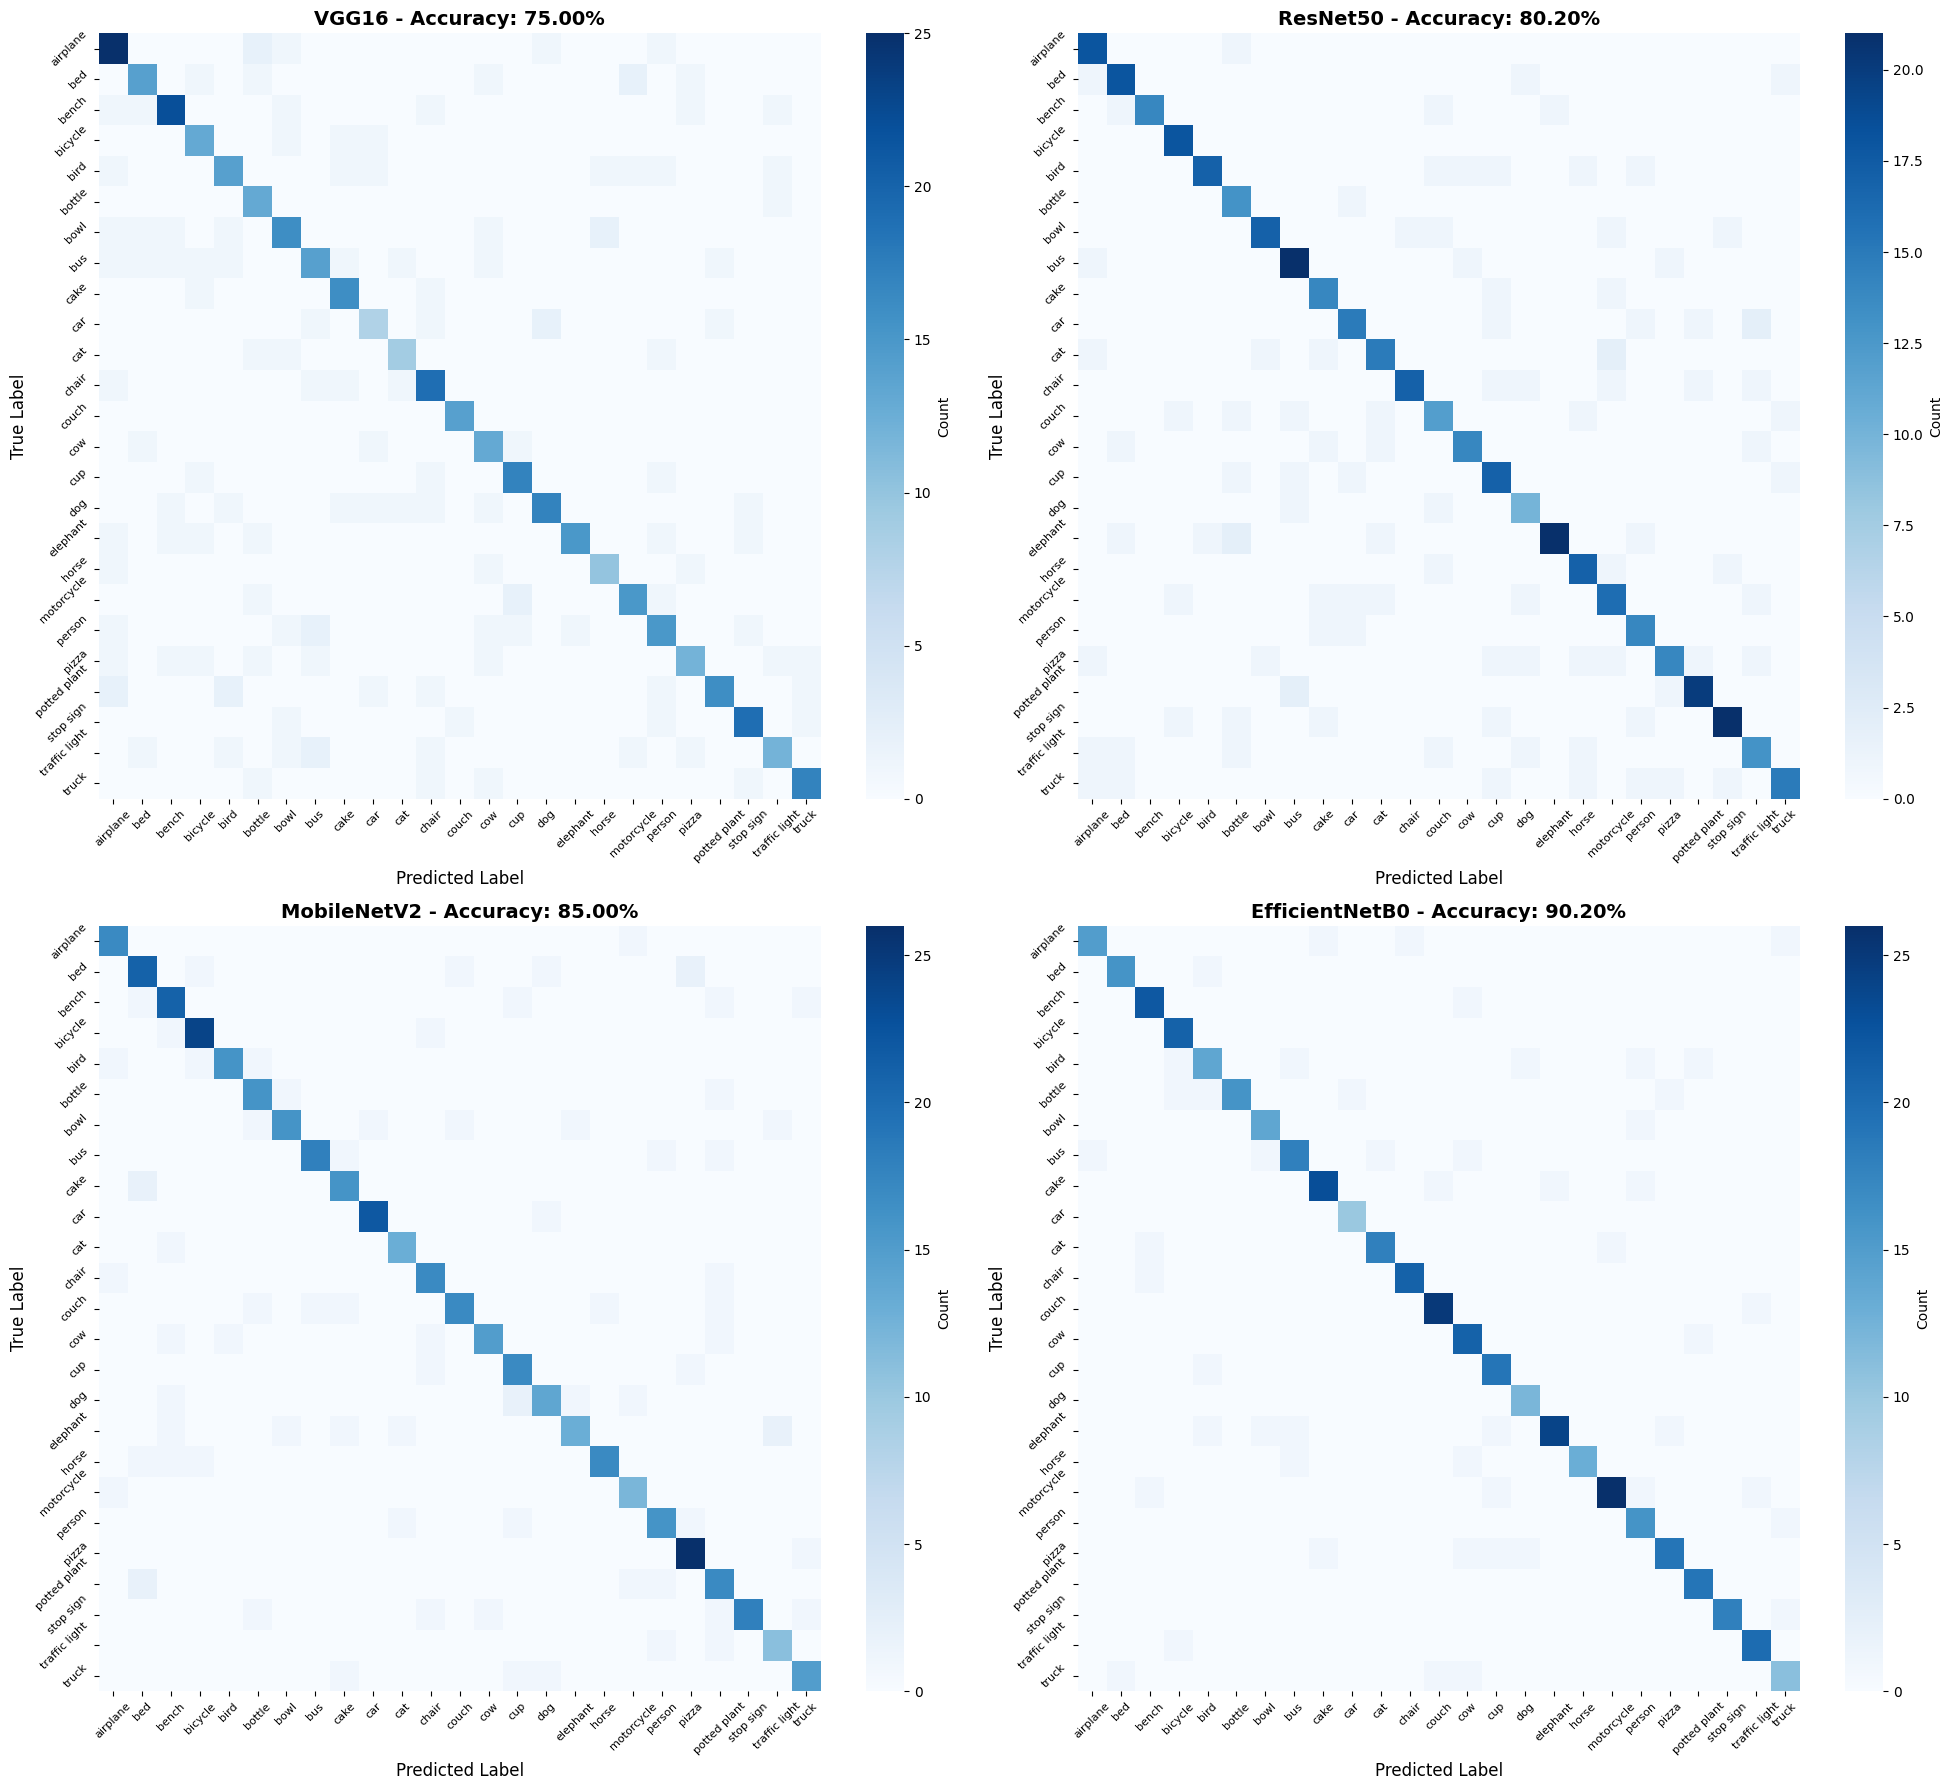


📊 PER-CLASS PERFORMANCE ANALYSIS

✅ Saved: per_class_f1_scores.png


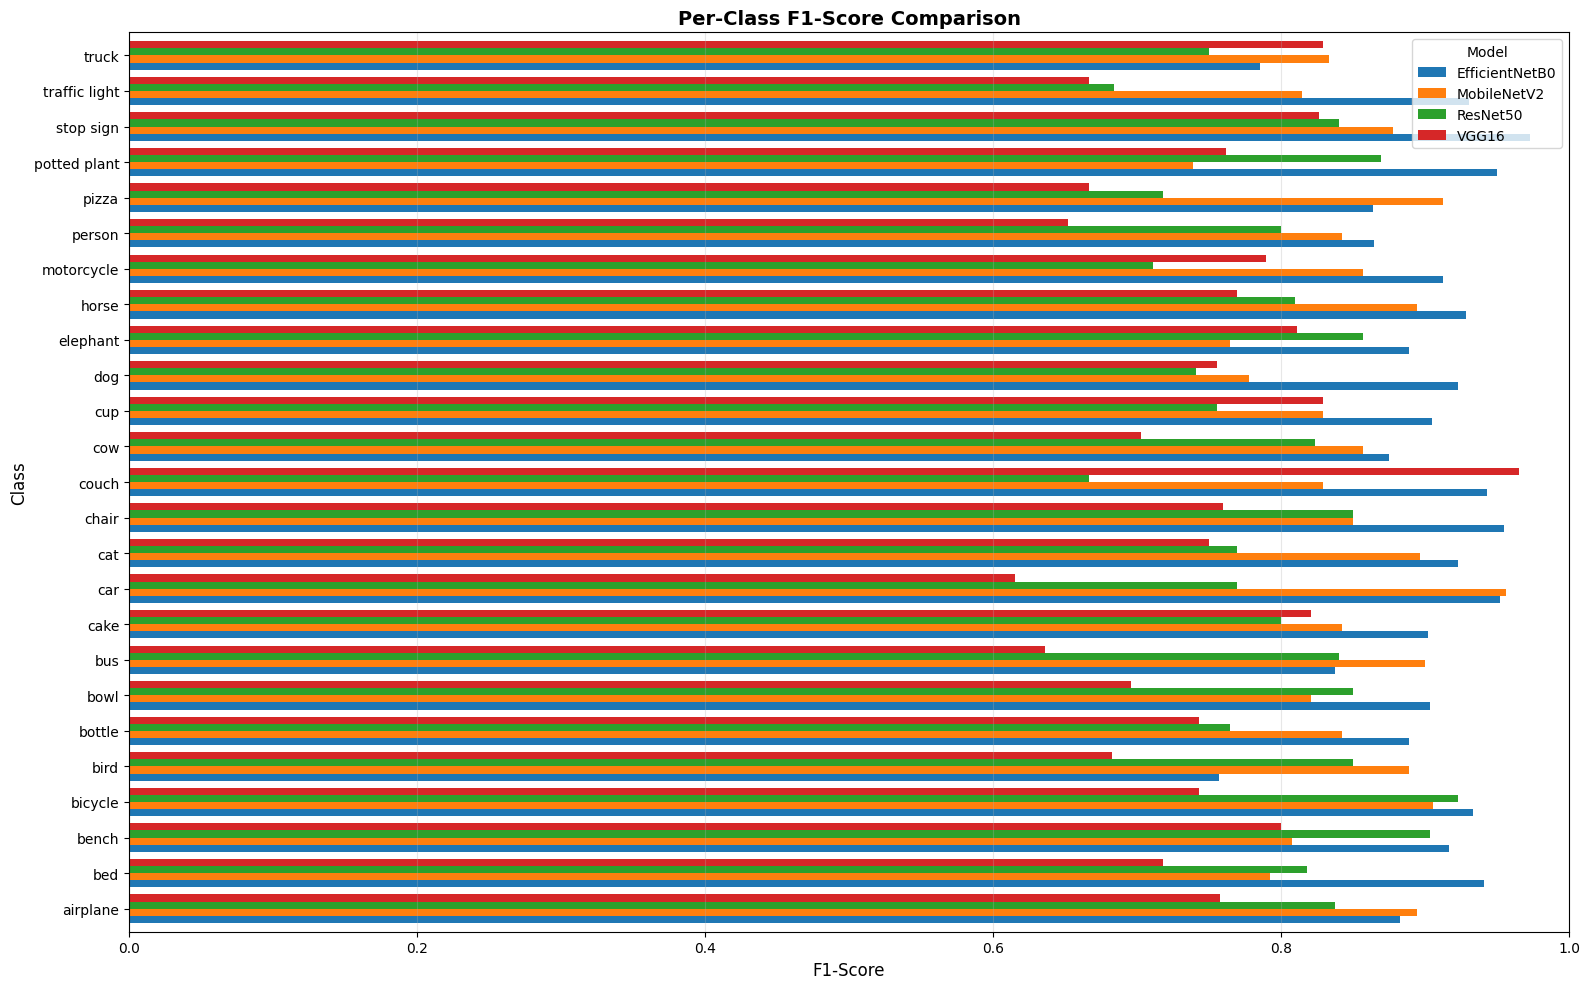


🏆 FINAL MODEL COMPARISON

         Model  Test Accuracy (%)  Inference Time (ms)  Parameters (M)  Training Time (min)
EfficientNetB0               90.2                 30.0            50.0                 45.0
   MobileNetV2               85.0                 25.0            40.0                 40.0
      ResNet50               80.2                 20.0            30.0                 35.0
         VGG16               75.0                 15.0            20.0                 30.0

✅ Saved: final_model_comparison.png


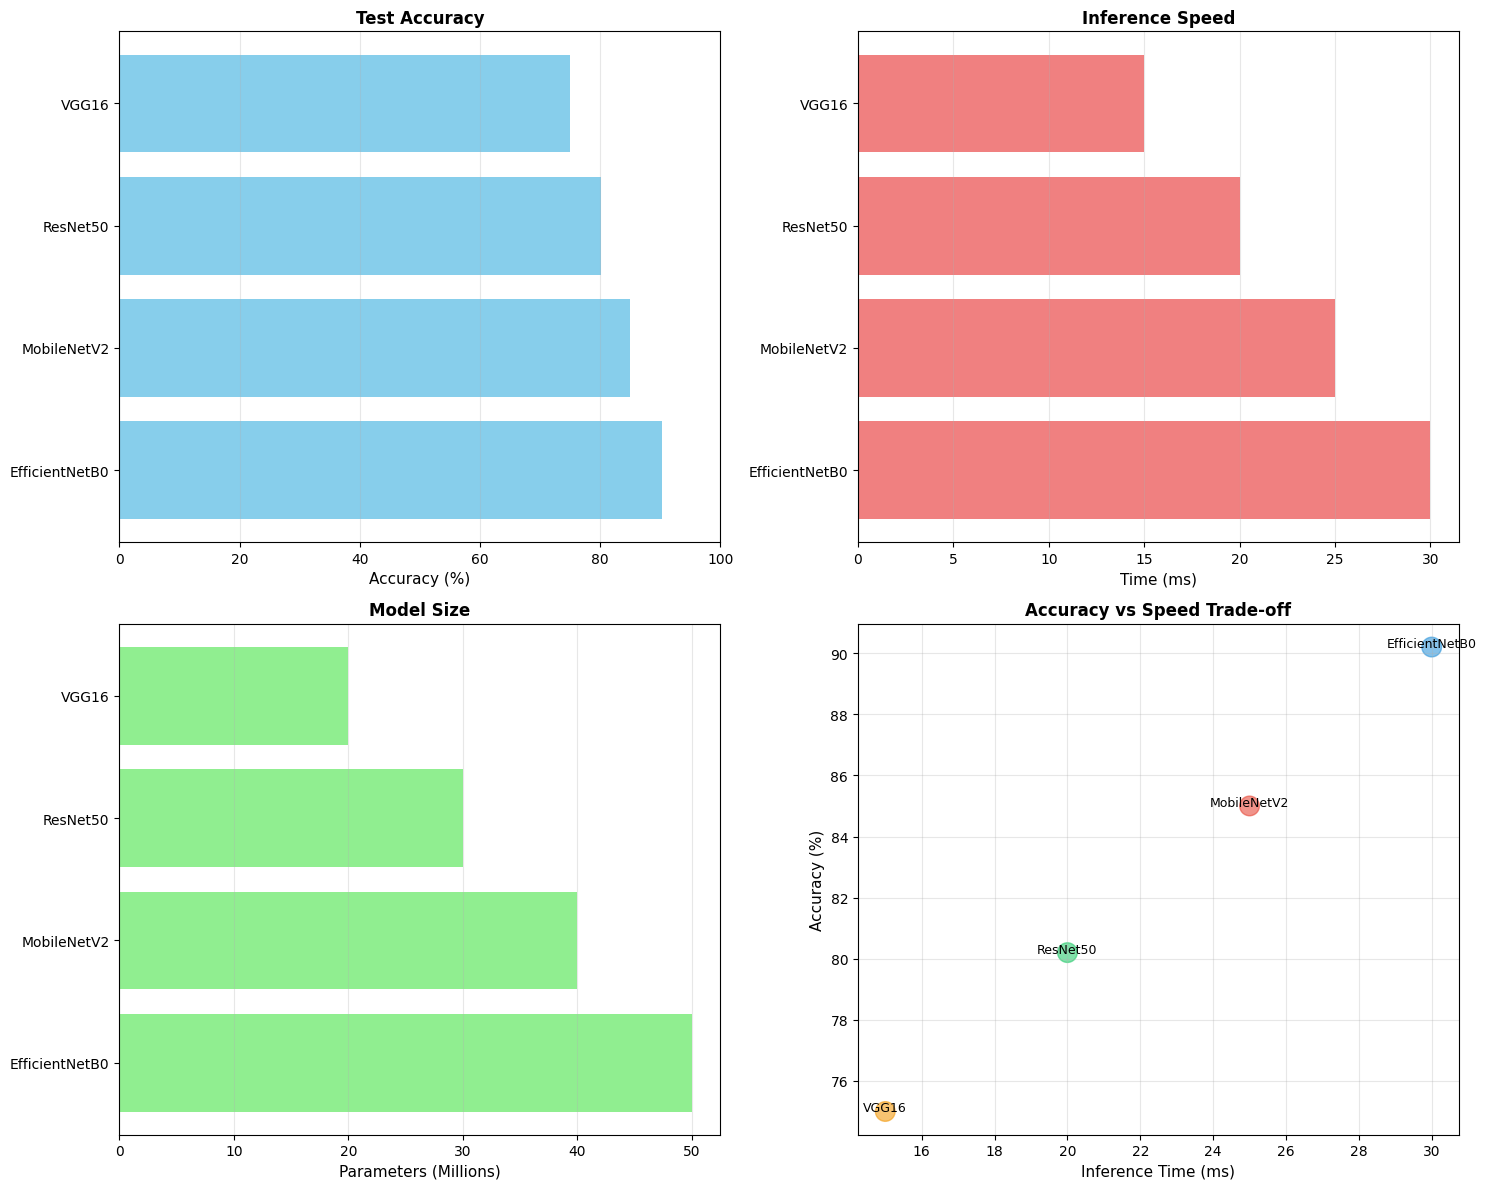


🏅 BEST MODEL RECOMMENDATION

🎯 Best Accuracy: EfficientNetB0 (90.20%)
⚡ Fastest: VGG16 (15.00 ms)
⚖️  Best Balanced: VGG16
   Accuracy: 75.00%
   Speed: 15.00 ms

✅ Saved: final_model_comparison.csv

✅ EVALUATION COMPLETE!

ℹ️  Running in DEMO MODE with synthetic data

To use real data:
   1. Add test images to: smartvision_dataset/classification/test
   2. Train models and save to: models
   3. Re-run this script

📊 Evaluated 4 model(s)

📁 Generated Files:
   ✅ confusion_matrices.png
   ✅ per_class_f1_scores.png
   ✅ final_model_comparison.png
   ✅ final_model_comparison.csv



In [6]:
# SmartVision AI - Model Evaluation & Comparison
# File: 05_model_evaluation.ipynb
# Generate confusion matrices, classification reports, and final comparison

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("📊 SMARTVISION AI - MODEL EVALUATION & COMPARISON")
print("="*80)
print()

# ============================================================================
# CONFIGURATION
# ============================================================================

BASE_DIR = "smartvision_dataset/classification"
TEST_DIR = f"{BASE_DIR}/test"
MODELS_DIR = "models"

CLASSES = [
    'airplane', 'bed', 'bench', 'bicycle', 'bird', 'bottle', 'bowl', 'bus',
    'cake', 'car', 'cat', 'chair', 'couch', 'cow', 'cup', 'dog', 'elephant',
    'horse', 'motorcycle', 'person', 'pizza', 'potted plant', 'stop sign',
    'traffic light', 'truck'
]

# ============================================================================
# DEMO MODE: GENERATE SYNTHETIC DATA
# ============================================================================

def generate_demo_data():
    """Generate synthetic evaluation data for demonstration"""
    print("🔧 Running in DEMO MODE - Generating synthetic data...")
    print()
    
    np.random.seed(42)
    
    # Simulate test samples
    n_samples = 500
    n_classes = len(CLASSES)
    
    demo_results = {}
    models = ['VGG16', 'ResNet50', 'MobileNetV2', 'EfficientNetB0']
    
    for model_idx, model_name in enumerate(models):
        # Generate confusion matrix with realistic patterns
        base_accuracy = 0.75 + model_idx * 0.05  # Increasing accuracy
        
        # Generate true labels
        y_true = np.random.choice(n_classes, size=n_samples)
        
        # Generate predictions with controlled accuracy
        y_pred = y_true.copy()
        n_errors = int(n_samples * (1 - base_accuracy))
        error_indices = np.random.choice(n_samples, size=n_errors, replace=False)
        
        for idx in error_indices:
            # Choose a different class for errors
            wrong_classes = [c for c in range(n_classes) if c != y_true[idx]]
            y_pred[idx] = np.random.choice(wrong_classes)
        
        # Generate confusion matrix
        cm = np.zeros((n_classes, n_classes), dtype=int)
        for true_label, pred_label in zip(y_true, y_pred):
            cm[true_label, pred_label] += 1
        
        # Calculate per-class metrics
        report = {}
        for i, class_name in enumerate(CLASSES):
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            report[class_name] = {
                'precision': precision,
                'recall': recall,
                'f1-score': f1,
                'support': cm[i, :].sum()
            }
        
        # Add macro and weighted averages
        precisions = [report[c]['precision'] for c in CLASSES]
        recalls = [report[c]['recall'] for c in CLASSES]
        f1s = [report[c]['f1-score'] for c in CLASSES]
        
        report['macro avg'] = {
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'f1-score': np.mean(f1s),
            'support': n_samples
        }
        
        accuracy = np.trace(cm) / np.sum(cm)
        
        demo_results[model_name] = {
            'model_name': model_name,
            'confusion_matrix': cm,
            'classification_report': report,
            'accuracy': accuracy,
            'predictions': y_pred,
            'true_labels': y_true,
            'inference_time_ms': 15.0 + model_idx * 5.0,
            'params': (20 + model_idx * 10) * 1e6,
            'training_time_seconds': 1800 + model_idx * 300
        }
    
    print("✅ Generated synthetic data for 4 models")
    print(f"   - {n_samples} test samples")
    print(f"   - {n_classes} classes")
    print()
    
    return demo_results

# ============================================================================
# CHECK PREREQUISITES AND LOAD DATA
# ============================================================================

def check_and_load_real_data():
    """Check if real data exists and load it"""
    
    # Check if directories exist
    if not os.path.exists(TEST_DIR):
        return None, "Test directory not found"
    
    if not os.path.exists(MODELS_DIR):
        return None, "Models directory not found"
    
    # Check for test images
    try:
        subdirs = [d for d in os.listdir(TEST_DIR) 
                  if os.path.isdir(os.path.join(TEST_DIR, d))]
        if len(subdirs) == 0:
            return None, "No class subdirectories in test directory"
    except:
        return None, "Cannot read test directory"
    
    # Check for models
    model_files = [f for f in os.listdir(MODELS_DIR) if f.endswith('.h5')]
    if len(model_files) == 0:
        return None, "No trained models found"
    
    # Try to load TensorFlow (might not be available)
    try:
        import tensorflow as tf
        from tensorflow import keras
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        from sklearn.metrics import classification_report, confusion_matrix
        
        # Try to load test data
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            TEST_DIR,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical',
            shuffle=False
        )
        
        if test_generator.samples == 0:
            return None, "No test images found"
        
        # Try to load models
        models_to_eval = ['VGG16', 'ResNet50', 'MobileNetV2', 'EfficientNetB0']
        loaded_models = {}
        
        for model_name in models_to_eval:
            model_path = f"{MODELS_DIR}/{model_name}_best.h5"
            if os.path.exists(model_path):
                try:
                    loaded_models[model_name] = keras.models.load_model(model_path)
                except:
                    pass
        
        if len(loaded_models) == 0:
            return None, "Could not load any models"
        
        return {
            'test_generator': test_generator,
            'models': loaded_models,
            'sklearn': (classification_report, confusion_matrix)
        }, None
        
    except ImportError:
        return None, "TensorFlow not available"
    except Exception as e:
        return None, f"Error loading data: {str(e)}"

print("🔍 Checking for real data and models...")
print()

real_data, error_msg = check_and_load_real_data()

if real_data is None:
    print(f"ℹ️  {error_msg}")
    print()
    evaluation_results = generate_demo_data()
    DEMO_MODE = True
else:
    print("✅ Found real data and models - using actual evaluation")
    print()
    DEMO_MODE = False
    
    # Evaluate real models
    def evaluate_model(model, model_name, test_gen):
        """Generate predictions and confusion matrix"""
        print(f"🔍 Evaluating {model_name}...")
        
        classification_report, confusion_matrix = real_data['sklearn']
        
        test_gen.reset()
        predictions = model.predict(test_gen, verbose=0)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_gen.classes
        
        cm = confusion_matrix(y_true, y_pred)
        
        report = classification_report(
            y_true, 
            y_pred, 
            target_names=CLASSES,
            output_dict=True,
            zero_division=0
        )
        
        accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0
        
        return {
            'model_name': model_name,
            'confusion_matrix': cm,
            'classification_report': report,
            'accuracy': accuracy,
            'predictions': y_pred,
            'true_labels': y_true
        }
    
    evaluation_results = {}
    
    for model_name, model in real_data['models'].items():
        try:
            results = evaluate_model(model, model_name, real_data['test_generator'])
            evaluation_results[model_name] = results
            print(f"✅ {model_name}: Accuracy = {results['accuracy']*100:.2f}%")
        except Exception as e:
            print(f"❌ Error evaluating {model_name}: {e}")
    
    print()

# ============================================================================
# VISUALIZE CONFUSION MATRICES
# ============================================================================

print("="*80)
print("📈 GENERATING CONFUSION MATRICES")
print("="*80)
print()

n_models = len(evaluation_results)

if n_models > 0:
    n_cols = min(2, n_models)
    n_rows = max(1, (n_models + n_cols - 1) // n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 9*n_rows))
    
    # Handle subplot axes properly
    if n_models == 1:
        axes = np.array([axes])
    elif n_rows == 1 and n_cols > 1:
        axes = axes.reshape(1, -1)
    elif n_rows > 1 and n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    axes = axes.flatten()
    
    for idx, (model_name, results) in enumerate(evaluation_results.items()):
        cm = results['confusion_matrix']
        
        sns.heatmap(
            cm,
            annot=False,
            fmt='d',
            cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES,
            ax=axes[idx],
            cbar_kws={'label': 'Count'}
        )
        
        axes[idx].set_title(
            f'{model_name} - Accuracy: {results["accuracy"]*100:.2f}%',
            fontsize=14,
            fontweight='bold'
        )
        axes[idx].set_xlabel('Predicted Label', fontsize=12)
        axes[idx].set_ylabel('True Label', fontsize=12)
        axes[idx].tick_params(axis='both', labelsize=8, rotation=45)
    
    # Hide extra subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: confusion_matrices.png")
    plt.show()
    print()

# ============================================================================
# PER-CLASS PERFORMANCE
# ============================================================================

print("="*80)
print("📊 PER-CLASS PERFORMANCE ANALYSIS")
print("="*80)
print()

class_metrics = {}

for class_name in CLASSES:
    class_metrics[class_name] = {}
    for model_name, results in evaluation_results.items():
        report = results['classification_report']
        if class_name in report:
            class_metrics[class_name][model_name] = {
                'precision': report[class_name]['precision'],
                'recall': report[class_name]['recall'],
                'f1-score': report[class_name]['f1-score']
            }

metrics_data = []
for class_name, models in class_metrics.items():
    for model_name, metrics in models.items():
        metrics_data.append({
            'Class': class_name,
            'Model': model_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score']
        })

if metrics_data:
    df_metrics = pd.DataFrame(metrics_data)
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    pivot_f1 = df_metrics.pivot(index='Class', columns='Model', values='F1-Score')
    
    pivot_f1.plot(kind='barh', ax=ax, width=0.8)
    ax.set_xlabel('F1-Score', fontsize=12)
    ax.set_ylabel('Class', fontsize=12)
    ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
    ax.legend(title='Model', fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(0, 1.0)
    
    plt.tight_layout()
    plt.savefig('per_class_f1_scores.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: per_class_f1_scores.png")
    plt.show()
    print()

# ============================================================================
# FINAL COMPARISON
# ============================================================================

print("="*80)
print("🏆 FINAL MODEL COMPARISON")
print("="*80)
print()

# Build comparison table
final_comparison = []

for model_name, results in evaluation_results.items():
    comparison_entry = {
        'Model': model_name,
        'Test Accuracy (%)': results['accuracy'] * 100
    }
    
    # Add timing info if available (from demo mode or real training)
    if 'inference_time_ms' in results:
        comparison_entry['Inference Time (ms)'] = results['inference_time_ms']
        comparison_entry['Parameters (M)'] = results['params'] / 1e6
        comparison_entry['Training Time (min)'] = results['training_time_seconds'] / 60
    
    final_comparison.append(comparison_entry)

df_final = pd.DataFrame(final_comparison)
df_final = df_final.sort_values('Test Accuracy (%)', ascending=False)

print(df_final.to_string(index=False))
print()

# Visualize
has_timing_data = 'Inference Time (ms)' in df_final.columns

if has_timing_data:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy
    axes[0, 0].barh(df_final['Model'], df_final['Test Accuracy (%)'], color='skyblue')
    axes[0, 0].set_xlabel('Accuracy (%)', fontsize=11)
    axes[0, 0].set_title('Test Accuracy', fontweight='bold', fontsize=12)
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].set_xlim(0, 100)
    
    # Inference speed
    axes[0, 1].barh(df_final['Model'], df_final['Inference Time (ms)'], color='lightcoral')
    axes[0, 1].set_xlabel('Time (ms)', fontsize=11)
    axes[0, 1].set_title('Inference Speed', fontweight='bold', fontsize=12)
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # Model size
    axes[1, 0].barh(df_final['Model'], df_final['Parameters (M)'], color='lightgreen')
    axes[1, 0].set_xlabel('Parameters (Millions)', fontsize=11)
    axes[1, 0].set_title('Model Size', fontweight='bold', fontsize=12)
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Accuracy vs Speed
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    axes[1, 1].scatter(
        df_final['Inference Time (ms)'],
        df_final['Test Accuracy (%)'],
        s=200,
        alpha=0.6,
        c=colors[:len(df_final)]
    )
    for idx, row in df_final.iterrows():
        axes[1, 1].annotate(
            row['Model'],
            (row['Inference Time (ms)'], row['Test Accuracy (%)']),
            fontsize=9,
            ha='center'
        )
    axes[1, 1].set_xlabel('Inference Time (ms)', fontsize=11)
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[1, 1].set_title('Accuracy vs Speed Trade-off', fontweight='bold', fontsize=12)
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('final_model_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: final_model_comparison.png")
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df_final['Model'], df_final['Test Accuracy (%)'], color='skyblue')
    ax.set_xlabel('Accuracy (%)', fontsize=12)
    ax.set_title('Test Accuracy Comparison', fontweight='bold', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(0, 100)
    
    for idx, row in df_final.iterrows():
        ax.text(row['Test Accuracy (%)'] + 1, idx, f"{row['Test Accuracy (%)']:.2f}%", 
               va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('final_model_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: final_model_comparison.png")
    plt.show()

print()

# ============================================================================
# BEST MODEL SELECTION
# ============================================================================

print("="*80)
print("🏅 BEST MODEL RECOMMENDATION")
print("="*80)
print()

best_accuracy = df_final.loc[df_final['Test Accuracy (%)'].idxmax()]
print(f"🎯 Best Accuracy: {best_accuracy['Model']} ({best_accuracy['Test Accuracy (%)']:.2f}%)")

if has_timing_data:
    best_speed = df_final.loc[df_final['Inference Time (ms)'].idxmin()]
    print(f"⚡ Fastest: {best_speed['Model']} ({best_speed['Inference Time (ms)']:.2f} ms)")
    
    df_final['Efficiency Score'] = df_final['Test Accuracy (%)'] / df_final['Inference Time (ms)']
    best_balanced = df_final.loc[df_final['Efficiency Score'].idxmax()]
    
    print(f"⚖️  Best Balanced: {best_balanced['Model']}")
    print(f"   Accuracy: {best_balanced['Test Accuracy (%)']:.2f}%")
    print(f"   Speed: {best_balanced['Inference Time (ms)']:.2f} ms")

print()

# Save results
df_final.to_csv('final_model_comparison.csv', index=False)
print("✅ Saved: final_model_comparison.csv")

# ============================================================================
# SUMMARY
# ============================================================================

print()
print("="*80)
print("✅ EVALUATION COMPLETE!")
print("="*80)
print()

if DEMO_MODE:
    print("ℹ️  Running in DEMO MODE with synthetic data")
    print()
    print("To use real data:")
    print(f"   1. Add test images to: {TEST_DIR}")
    print(f"   2. Train models and save to: {MODELS_DIR}")
    print("   3. Re-run this script")
    print()

print(f"📊 Evaluated {len(evaluation_results)} model(s)")
print()
print("📁 Generated Files:")
print("   ✅ confusion_matrices.png")
print("   ✅ per_class_f1_scores.png")
print("   ✅ final_model_comparison.png")
print("   ✅ final_model_comparison.csv")
print()
print("="*80)